In [1]:
%reload_ext autoreload
%autoreload 2

from helpers import *
from spice_net import *

import numpy as np
import networkx as nxs
import tqdm
import random
import json

import PySpice
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = "ngspice-shared" 
import PySpice.Spice.NgSpice.Server
PySpice.Spice.NgSpice.Server.SpiceServer.SPICE_COMMAND = 'ngspice'

In [2]:
import PySpice.Spice.NgSpice.Shared

instance = PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance()

Unsupported Ngspice version 43


In [3]:
data = np.load("../data/xor_train_data_no_scale.npz")

In [4]:
def make_test_net(size, instance):
    seed = 0

    grid_size = size

    np.random.seed(seed)

    grid_graph = nx.grid_graph([grid_size, grid_size], periodic=True)
    grid_graph.add_node((-1, -1))

    for e in grid_graph.edges:
        # grid_graph[e[0]][e[1]]['weight'] = 0.5                           # init to max value
        grid_graph[e[0]][e[1]]['weight'] = random.uniform(0.1, 0.9)       # random value

    node_cfg = (np.array([[5, 16], [7, 16], [13, 16], [15, 16]]), np.array([[10, 0]]))
    net: TransistorNetwork = TransistorNetwork("profiling", con_graph=grid_graph, node_cfg=node_cfg, solver=instance, epsilon=1e-16)
    return net

In [48]:
net = make_test_net(4, instance)

In [49]:
net.__nodes__

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16'], dtype='<U2')

In [50]:
simulator = net.cached_simulator

In [51]:
# simulator.node_set(**{"0": 5})

In [57]:
net._prepare_simulation(data["inputs"])

In [58]:
res = net._run_simulation()

In [59]:
print(res.simulation)

.title profiling
.subckt Transistor_edge t_D t_S vgs=0.5
V1 t_G t_S {vgs}
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends Transistor_edge
B1 5 16 v={pwl(V(index), 1, 0, 2, 0, 3, 0, 4, 0)}
B2 7 16 v={pwl(V(index), 1, 1, 2, 1, 3, 1, 4, 1)}
B3 13 16 v={pwl(V(index), 1, 0, 2, 0, 3, 1, 4, 1)}
B4 15 16 v={pwl(V(index), 1, 0, 2, 1, 3, 0, 4, 1)}
Vindex index 0 1
X1 0 4 Transistor_edge vgs=0.19718588431337594
X2 0 12 Transistor_edge vgs=0.4980523577669995
X3 0 1 Transistor_edge vgs=0.49603468768987513
X4 0 3 Transistor_edge vgs=0.28353986573276596
X5 1 5 Transistor_edge vgs=0.4494069089902031
X6 1 13 Transistor_edge vgs=0.7919403366588326
X7 1 2 Transistor_edge vgs=0.5526933106063622
X8 2 6 Transistor_edge vgs=0.11141519786273567
X9 2 14 Transistor_edge vgs=0.598462803714068
X10 2 3 Transistor_edge vgs=0.721793157324825
X11 3 7 Transistor_edge vgs=0.40261004914109555
X12 3 15 Transistor_edge vgs=0.437085624009104
X13 4 8 Transistor_edge vgs=0.5586299838086015
X14 4 5 Transistor_edge vgs=0.86038

In [60]:
res.nodes.get("1")

WaveForm 1 [-0.19910725]@V

In [56]:
simulator.options("KLU")
# simulator.options("Sparse")

In [32]:
del simulator._options['Sparse']

KeyError: 'Sparse'

In [13]:
print(simulator)

.title profiling
.subckt Transistor_edge t_D t_S vgs=0.5
V1 t_G t_S {vgs}
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends Transistor_edge
B1 5 16 v={pwl(V(index), 1, 0, 2, 0, 3, 0, 4, 0)}
B2 7 16 v={pwl(V(index), 1, 1, 2, 1, 3, 1, 4, 1)}
B3 13 16 v={pwl(V(index), 1, 0, 2, 0, 3, 1, 4, 1)}
B4 15 16 v={pwl(V(index), 1, 0, 2, 1, 3, 0, 4, 1)}
Vindex index 0 1
X1 0 4 Transistor_edge vgs=0.260735994147437
X2 0 12 Transistor_edge vgs=0.5448806256553254
X3 0 1 Transistor_edge vgs=0.798218868526189
X4 0 3 Transistor_edge vgs=0.4437111326510904
X5 1 5 Transistor_edge vgs=0.2743554315582233
X6 1 13 Transistor_edge vgs=0.4308738696519636
X7 1 2 Transistor_edge vgs=0.7753388459186505
X8 2 6 Transistor_edge vgs=0.6261420996928565
X9 2 14 Transistor_edge vgs=0.28570622679790214
X10 2 3 Transistor_edge vgs=0.3342906930750964
X11 3 7 Transistor_edge vgs=0.6909801066943563
X12 3 15 Transistor_edge vgs=0.40509074493042296
X13 4 8 Transistor_edge vgs=0.8198752945824408
X14 4 5 Transistor_edge vgs=0.7758552

In [36]:
print(net)

.title profiling
.subckt Transistor_edge t_D t_S vgs=0.5
V1 t_G t_S {vgs}
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends Transistor_edge
B1 5 16 v={pwl(V(index), 1, 0, 2, 0, 3, 0, 4, 0)}
B2 7 16 v={pwl(V(index), 1, 1, 2, 1, 3, 1, 4, 1)}
B3 13 16 v={pwl(V(index), 1, 0, 2, 0, 3, 1, 4, 1)}
B4 15 16 v={pwl(V(index), 1, 0, 2, 1, 3, 0, 4, 1)}
Vindex index 0 1
X1 0 4 Transistor_edge vgs=0.7700918111915457
X2 0 12 Transistor_edge vgs=0.3439144358781264
X3 0 1 Transistor_edge vgs=0.30548520205331176
X4 0 3 Transistor_edge vgs=0.38673179077497843
X5 1 5 Transistor_edge vgs=0.875637672998824
X6 1 13 Transistor_edge vgs=0.7983799996575992
X7 1 2 Transistor_edge vgs=0.22513655264046495
X8 2 6 Transistor_edge vgs=0.7052222454089927
X9 2 14 Transistor_edge vgs=0.33555483141777365
X10 2 3 Transistor_edge vgs=0.4873338064501942
X11 3 7 Transistor_edge vgs=0.33052563589589845
X12 3 15 Transistor_edge vgs=0.7473111400764072
X13 4 8 Transistor_edge vgs=0.8709080304296537
X14 4 5 Transistor_edge vgs=0.459

In [37]:
instance.set("R1 1 0 1")

In [38]:
print(instance.listing)

<bound method NgSpiceShared.listing of <PySpice.Spice.NgSpice.Shared.NgSpiceShared object at 0x113868730>>


In [39]:
print(net)

.title profiling
.subckt Transistor_edge t_D t_S vgs=0.5
V1 t_G t_S {vgs}
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends Transistor_edge
B1 5 16 v={pwl(V(index), 1, 0, 2, 0, 3, 0, 4, 0)}
B2 7 16 v={pwl(V(index), 1, 1, 2, 1, 3, 1, 4, 1)}
B3 13 16 v={pwl(V(index), 1, 0, 2, 0, 3, 1, 4, 1)}
B4 15 16 v={pwl(V(index), 1, 0, 2, 1, 3, 0, 4, 1)}
Vindex index 0 1
X1 0 4 Transistor_edge vgs=0.7700918111915457
X2 0 12 Transistor_edge vgs=0.3439144358781264
X3 0 1 Transistor_edge vgs=0.30548520205331176
X4 0 3 Transistor_edge vgs=0.38673179077497843
X5 1 5 Transistor_edge vgs=0.875637672998824
X6 1 13 Transistor_edge vgs=0.7983799996575992
X7 1 2 Transistor_edge vgs=0.22513655264046495
X8 2 6 Transistor_edge vgs=0.7052222454089927
X9 2 14 Transistor_edge vgs=0.33555483141777365
X10 2 3 Transistor_edge vgs=0.4873338064501942
X11 3 7 Transistor_edge vgs=0.33052563589589845
X12 3 15 Transistor_edge vgs=0.7473111400764072
X13 4 8 Transistor_edge vgs=0.8709080304296537
X14 4 5 Transistor_edge vgs=0.459

## Benchmarks below

In [5]:
# number of netlist lines
len(str(net).split("\n"))

NameError: name 'net' is not defined

In [10]:
# initialize statistics
statistics = {}

netlist_fields = ['Subckt and Param expansion time','Netlist parsing time']
loading_fields = ['Netlist loading time','Matrix load time','Transient load time']
matrix_fields = ['Matrix synchronize time','Matrix reorder time','Matrix factor time','Matrix solve time']
misc_fields = ['Total analysis time (seconds)', 'Total iterations', 'Circuit Equations','Circuit original non-zeroes','Circuit fill-in non-zeroes', 'Circuit total non-zeroes']
all_fields = netlist_fields + loading_fields + matrix_fields + misc_fields

In [11]:
NET_SIZES = [4, 10, 20, 30, 50]
n_iters = 25

In [12]:
for size in tqdm.tqdm(NET_SIZES[::-1]):
    statistics[size] = {}

    instance.remove_circuit()
    net = make_test_net(size, instance)
    statistics[size]['Netlist lines'] = len(str(net).split("\n"))
    for i in tqdm.tqdm(range(n_iters), leave=False):
        net.solve(data['inputs'])
        
        for field in all_fields:
            if field not in statistics[size]:
                statistics[size][field] = instance.ressource_usage()[field]
            else:
                statistics[size][field] = (statistics[size][field] * i + instance.ressource_usage()[field]) / (i + 1)

        


  0%|          | 0/5 [00:00<?, ?it/s]

Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
 20%|██        | 1/5 [00:15<01:00, 15.22s/it]Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Using KLU as Direct Linear Solver
Usi

In [13]:
instance.ressource_usage()

{'Total elapsed time (seconds)': 73.923,
 'elapsed time since last call (seconds)': 3.844,
 'Total DRAM available': '16384.000 MB.',
 'DRAM currently available': '  54.984 MB.',
 'Maximum ngspice program size': '0 bytes.',
 'Current ngspice program size': ' 598.094 MB.',
 'Number of lines in the deck': 207,
 'Netlist loading time': 0,
 'Subckt and Param expansion time': 0.001,
 'Netlist parsing time': 0.001,
 'Nominal temperature': 27,
 'Operating temperature': 27,
 'Total iterations': 42,
 'Transient iterations': 0,
 'Circuit Equations': 87,
 'Circuit original non-zeroes': 373,
 'Circuit fill-in non-zeroes': 157,
 'Circuit total non-zeroes': 530,
 'Transient timepoints': 0,
 'Accepted timepoints': 0,
 'Rejected timepoints': 0,
 'Total analysis time (seconds)': 0.001,
 'Matrix load time': 0,
 'Matrix synchronize time': 0,
 'Matrix reorder time': 0,
 'Matrix factor time': 0.001,
 'Matrix solve time': 0,
 'Transient analysis time': 0,
 'Transient load time': 0,
 'Transient sync time': 0,

In [16]:
# uncomment to save results
EXPERIMENT_NAME = "profiling_globaldef_klu"
with open(f"{EXPERIMENT_NAME}.json", "w") as f:
    json.dump(statistics, f)

In [17]:
with open(f"{EXPERIMENT_NAME}.json", "r") as f:
    statistics = json.load(f)

## Data visualization

Text(0.5, 1.0, 'Netlist size vs. total solver iterations (steady state analysis)')

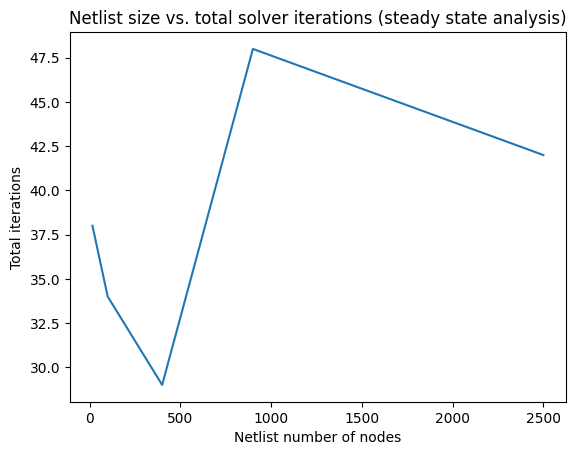

In [18]:
# plot netlist size vs. total iterations
import matplotlib.pyplot as plt
plt.plot([ss**2 for ss in NET_SIZES], [s['Total iterations'] for s in statistics.values()])
plt.xlabel("Netlist number of nodes")
plt.ylabel("Total iterations")
plt.title("Netlist size vs. total solver iterations (steady state analysis)")

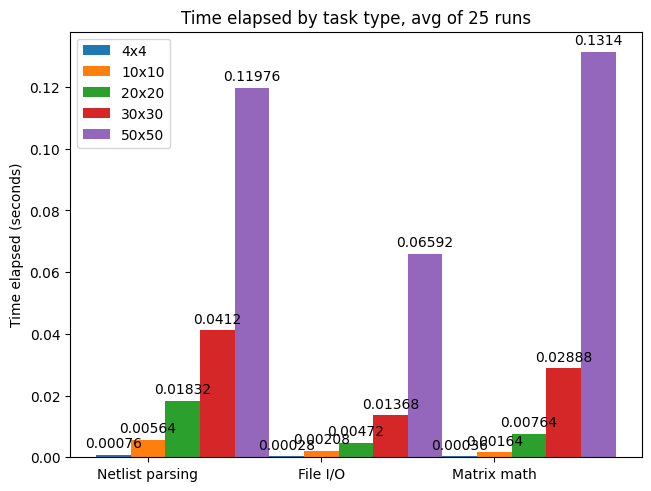

In [24]:
import matplotlib.pyplot as plt 

netlist_fields = ['Subckt and Param expansion time','Netlist parsing time']
loading_fields = ['Netlist loading time','Matrix load time','Transient load time']
matrix_fields = ['Matrix synchronize time','Matrix reorder time','Matrix factor time','Matrix solve time']

# grouped bar chart of size vs. time for each field
stat_totals = {
    size: [sum(statistics[str(size)][field] for field in netlist_fields),
    sum(statistics[str(size)][field] for field in loading_fields),
    sum(statistics[str(size)][field] for field in matrix_fields)]
    for size in NET_SIZES
}
all_fields = list(set(netlist_fields + loading_fields + matrix_fields))
trial_data = stat_totals

task_type = {"Netlist parsing": netlist_fields, "File I/O": loading_fields, "Matrix math": matrix_fields}

x = np.arange(len(task_type))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in trial_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=f"{attribute}x{attribute}")
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time elapsed (seconds)')
ax.set_title(f'Time elapsed by task type, avg of {n_iters} runs')
ax.set_xticks(x + width, task_type.keys())
ax.legend(loc='upper left', ncols=1)
# ax.set_ylim(0, 3.5)

plt.show()

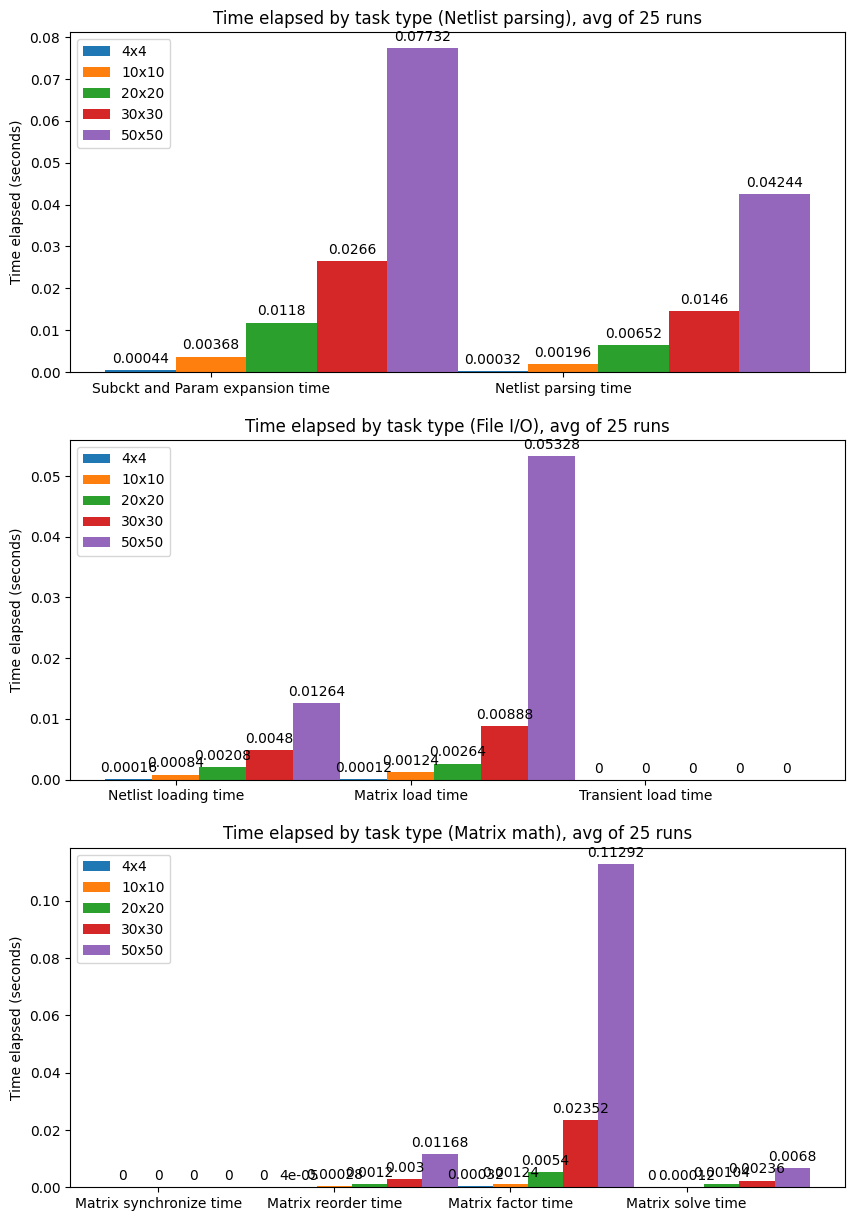

In [23]:
import matplotlib.pyplot as plt 

# grouped bar chart of size vs. time for each field
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (category, fields) in enumerate(zip(["Netlist parsing", "File I/O", "Matrix math"], [netlist_fields, loading_fields, matrix_fields])):
    stat_totals = {
        size: [statistics[str(size)][f] for f in fields]
        for size in NET_SIZES
    }

    x = np.arange(len(fields))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    for attribute, measurement in stat_totals.items():
        offset = width * multiplier
        rects = axs[i].bar(x + offset, measurement, width, label=f"{attribute}x{attribute}")
        axs[i].bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[i].set_ylabel('Time elapsed (seconds)')
    axs[i].set_title(f'Time elapsed by task type ({category}), avg of {n_iters} runs')
    axs[i].set_xticks(x + width, fields)
    axs[i].legend(loc='upper left', ncols=1)
    # axs[i].set_ylim(0, 3)

plt.show()

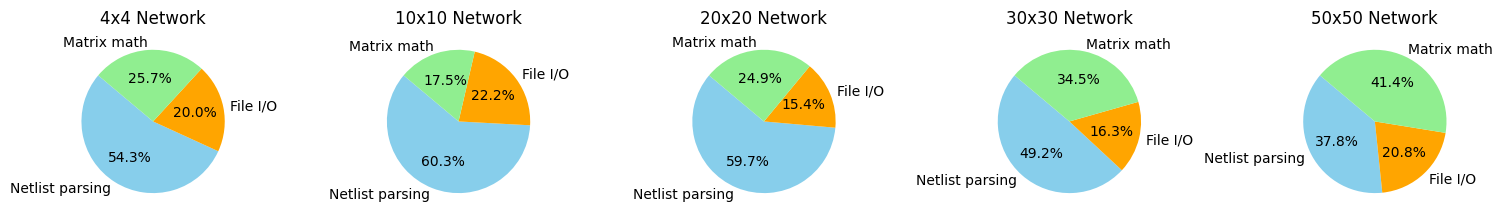

In [21]:
# pie chart showcasing the distribution of time spent on each task
fig, axs = plt.subplots(1, len(NET_SIZES), figsize=(15, 5))

for i, size in enumerate(NET_SIZES):
    # Get the time spent on each task for the current network size
    netlist_time = sum([statistics[str(size)][f] for f in netlist_fields])
    io_time = sum([statistics[str(size)][f] for f in loading_fields])
    math_time = sum([statistics[str(size)][f] for f in matrix_fields])

    # Data to plot
    times = [netlist_time, io_time, math_time]
    labels = ['Netlist parsing', 'File I/O', 'Matrix math']
    colors = ['skyblue', 'orange', 'lightgreen']

    # Plot pie chart
    axs[i].pie(times, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    axs[i].set_title(f'{size}x{size} Network')

plt.tight_layout()
plt.show()


/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_12474/3987539042.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(all_tasks))  # Generate distinct colors for each task


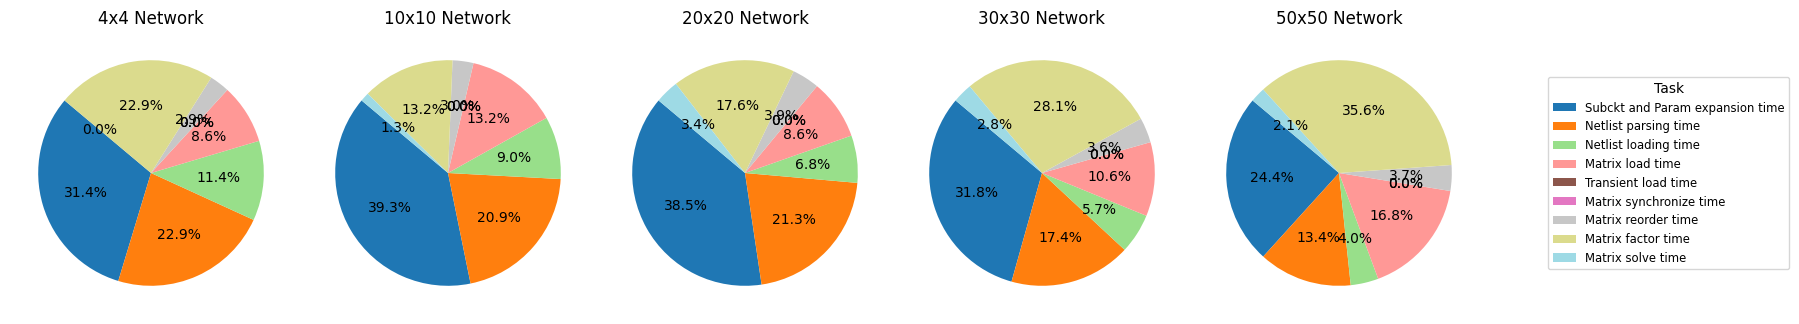

In [22]:
# Assuming `fields` is the list of all tasks (across all categories)
fig, axs = plt.subplots(1, len(NET_SIZES), figsize=(15, 5))

# Get unique task labels from all the fields combined
all_tasks = netlist_fields + loading_fields + matrix_fields
colors = plt.cm.get_cmap('tab20', len(all_tasks))  # Generate distinct colors for each task

for i, size in enumerate(NET_SIZES):
    # Get time spent on each individual task for the current network size
    task_times = {f: statistics[str(size)][f] for f in all_tasks}

    # Data to plot
    times = list(task_times.values())
    labels = list(task_times.keys())

    # Plot pie chart without labels (we'll add a single legend later)
    axs[i].pie(times, autopct='%1.1f%%', startangle=140, colors=colors(range(len(labels))))
    axs[i].set_title(f'{size}x{size} Network')

# Create a single legend
fig.legend(labels, loc="center right", title="Task", bbox_to_anchor=(1.2, 0.5), fontsize='small')

plt.tight_layout()
plt.show()

## Comparing unoptimized vs. optimized code

In [25]:
baseline = json.load(open("profiling_baseline.json"))
opt1 = json.load(open("profiling_param_subckt.json"))
opt2 = json.load(open("profiling_globaldef.json"))
opt3 = json.load(open("profiling_globaldef_klu.json"))

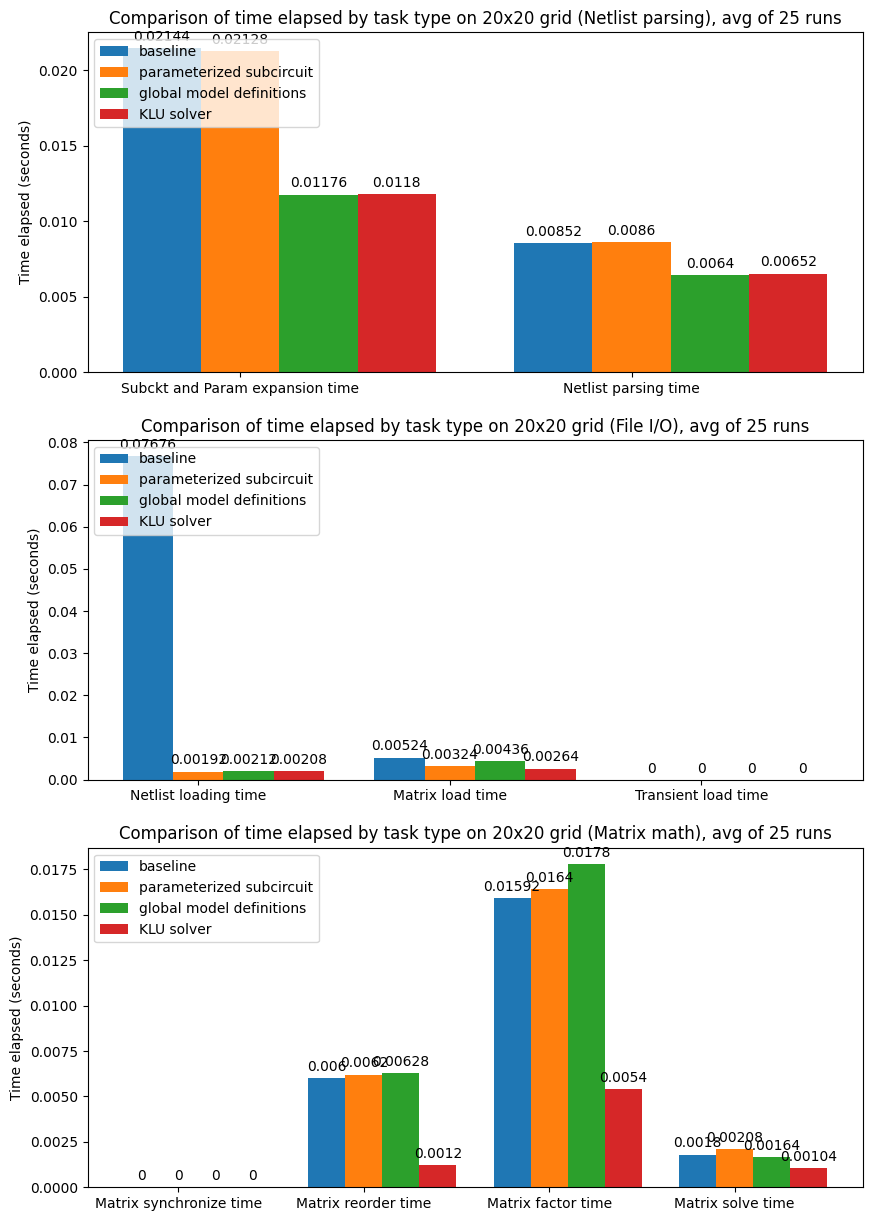

In [35]:
import matplotlib.pyplot as plt 

SIZE = str(20)

# grouped bar chart of size vs. time for each field
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (category, fields) in enumerate(zip(["Netlist parsing", "File I/O", "Matrix math"], [netlist_fields, loading_fields, matrix_fields])):
    stat_totals = {
        "baseline": [baseline[SIZE][f] for f in fields],
        "parameterized subcircuit": [opt1[SIZE][f] for f in fields],
        "global model definitions": [opt2[SIZE][f] for f in fields],
        "KLU solver": [opt3[SIZE][f] for f in fields]
    }

    x = np.arange(len(fields))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    for attribute, measurement in stat_totals.items():
        offset = width * multiplier
        rects = axs[i].bar(x + offset, measurement, width, label=f"{attribute}")
        axs[i].bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[i].set_ylabel('Time elapsed (seconds)')
    axs[i].set_title(f'Comparison of time elapsed by task type on {SIZE}x{SIZE} grid ({category}), avg of {n_iters} runs')
    axs[i].set_xticks(x + width, fields)
    axs[i].legend(loc='upper left', ncols=1)
    # axs[i].set_ylim(0, 3)

plt.show()

In [48]:
print(net)

.title profiling
.subckt Transistor_edge t_D t_S vgs=0.5
V1 t_G t_S {vgs}
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends Transistor_edge
B1 5 16
B2 7 16
B3 13 16
B4 15 16
B5 10 0
Vindex index 0 1
X1 0 4 Transistor_edge vgs=0.7968927824135439
X2 0 12 Transistor_edge vgs=0.48858724163023426
X3 0 1 Transistor_edge vgs=0.42243014894537156
X4 0 3 Transistor_edge vgs=0.48861152960974386
X5 1 5 Transistor_edge vgs=0.6519648845056174
X6 1 13 Transistor_edge vgs=0.5936547013034641
X7 1 2 Transistor_edge vgs=0.7158380575322731
X8 2 6 Transistor_edge vgs=0.5917245810592089
X9 2 14 Transistor_edge vgs=0.44292304511321234
X10 2 3 Transistor_edge vgs=0.22025212917592907
X11 3 7 Transistor_edge vgs=0.580824457956858
X12 3 15 Transistor_edge vgs=0.7335786212275416
X13 4 8 Transistor_edge vgs=0.7092544491009302
X14 4 5 Transistor_edge vgs=0.3224879813561745
X15 4 7 Transistor_edge vgs=0.7334275907057738
X16 5 9 Transistor_edge vgs=0.536250666946212
X17 5 6 Transistor_edge vgs=0.5289400787434186
X18 6 

In [19]:
# compare number of equations, matrix nonzeros, and lines of netlist
print("Netlist lines")
print("  Baseline: ", [baseline[str(size)]['Netlist lines'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Netlist lines'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Netlist lines'] for size in NET_SIZES])

print("Circuit Equations")
print("  Baseline: ", [baseline[str(size)]['Circuit Equations'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Circuit Equations'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Circuit Equations'] for size in NET_SIZES])

print("Circuit original non-zeroes")
print("  Baseline: ", [baseline[str(size)]['Circuit original non-zeroes'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Circuit original non-zeroes'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Circuit original non-zeroes'] for size in NET_SIZES])

print("Circuit fill-in non-zeroes")
print("  Baseline: ", [baseline[str(size)]['Circuit fill-in non-zeroes'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Circuit fill-in non-zeroes'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Circuit fill-in non-zeroes'] for size in NET_SIZES])

Netlist lines
  Baseline:  [263, 1607, 6407, 14407, 40007]
  Parameterized subcircuit:  [46, 214, 814, 1814, 5014]
  Global model:  [46, 214, 814, 1814, 5014]
Circuit Equations
  Baseline:  [87.0, 506.0, 2006.0, 4506.0, 12506.0]
  Parameterized subcircuit:  [87.0, 506.0, 2006.0, 4506.0, 12506.0]
  Global model:  [87.0, 506.0, 2006.0, 4506.0, 12506.0]
Circuit original non-zeroes
  Baseline:  [373.0, 2305.0, 9205.0, 20705.0, 57505.0]
  Parameterized subcircuit:  [373.0, 2305.0, 9205.0, 20705.0, 57505.0]
  Global model:  [373.0, 2305.0, 9205.0, 20705.0, 57505.0]
Circuit fill-in non-zeroes
  Baseline:  [99.0, 1592.0, 11446.0, 32212.0, 119501.0]
  Parameterized subcircuit:  [99.0, 1592.0, 11446.0, 32212.0, 119501.0]
  Global model:  [99.0, 1592.0, 11446.0, 32212.0, 119501.0]


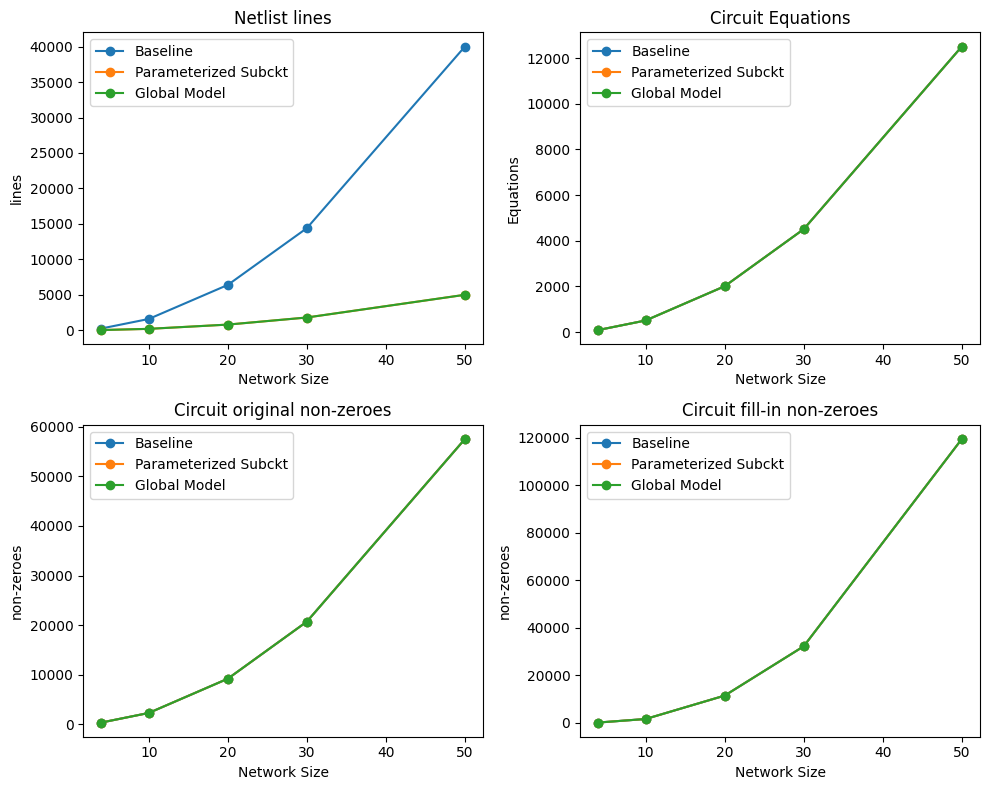

In [20]:
import matplotlib.pyplot as plt

# Data from your output
comp_fields = ['Netlist lines', 'Circuit Equations', 'Circuit original non-zeroes', 'Circuit fill-in non-zeroes']
netlist_metrics = {
    f: ([baseline[str(size)][f] for size in NET_SIZES], [opt1[str(size)][f] for size in NET_SIZES], [opt2[str(size)][f] for size in NET_SIZES])
    for f in comp_fields
}

# Plot configuration
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
titles = list(data.keys())

# Loop through and plot each metric
for i, (title, (baseline_metric, param_metric, global_metric)) in enumerate(netlist_metrics.items()):
    ax = axs[i // 2, i % 2]
    ax.plot(NET_SIZES, baseline_metric, label='Baseline', marker='o')
    ax.plot(NET_SIZES, param_metric, label='Parameterized Subckt', marker='o')
    ax.plot(NET_SIZES, global_metric, label='Global Model', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Network Size')
    ax.set_ylabel(title.split()[-1])
    ax.legend()

plt.tight_layout()
plt.show()


In [23]:
# find factor reduction in num lines
baseline_lines = [baseline[str(size)]['Netlist lines'] for size in NET_SIZES]
param_lines = [opt2[str(size)]['Netlist lines'] for size in NET_SIZES]

line_reduction = [bl / pl for bl, pl in zip(baseline_lines, param_lines)]
line_reduction

[5.717391304347826,
 7.509345794392523,
 7.871007371007371,
 7.9421168687982355,
 7.979058635819705]

In [24]:
# compare total times of runs for each
clock_time_baseline = [sum(baseline[str(size)][f] for f in netlist_fields + loading_fields + matrix_fields) for size in NET_SIZES]
clock_time_opt1 = [sum(opt1[str(size)][f] for f in netlist_fields + loading_fields + matrix_fields) for size in NET_SIZES]
clock_time_opt2 = [sum(opt2[str(size)][f] for f in netlist_fields + loading_fields + matrix_fields) for size in NET_SIZES]

print(clock_time_baseline)
print(clock_time_opt1)
print(clock_time_opt2)

speedups = [clock_time_baseline[i] / (clock_time_opt2[i]+1e-10) for i in range(len(NET_SIZES))]
speedups

[0.0020800000000000007, 0.01568000000000001, 0.13568, 0.6002800000000001, 4.18236]
[0.0015600000000000006, 0.010520000000000005, 0.059720000000000016, 0.217, 1.36312]
[0.0014400000000000003, 0.007360000000000002, 0.05036000000000002, 0.2085200000000001, 1.077]


[1.4444443441358095,
 2.130434753662572,
 2.6942017420687003,
 2.878764625513732,
 3.883342618023831]

In [32]:
baseline['50']['Total analysis time (seconds)']

1.0446

In [33]:
# Determine what portion of the time is spent in each section for netlists of each size

netlist_time_baseline = [sum(baseline[str(size)][f] for f in netlist_fields) / baseline[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]
netlist_time_opt1 = [sum(opt1[str(size)][f] for f in netlist_fields) / opt1[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]
netlist_time_opt2 = [sum(opt2[str(size)][f] for f in netlist_fields) / opt2[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]

print("Netlist operations")
print("Baseline:", netlist_time_baseline)
print("Opt1:", netlist_time_opt1)
print("Opt2:", netlist_time_opt2)

loading_time_baseline = [sum(baseline[str(size)][f] for f in loading_fields) / baseline[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]
loading_time_opt1 = [sum(opt1[str(size)][f] for f in loading_fields) / opt1[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]
loading_time_opt2 = [sum(opt2[str(size)][f] for f in loading_fields) / opt2[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]

print("Loading operations")
print("Baseline:", loading_time_baseline)
print("Opt1:", loading_time_opt1)
print("Opt2:", loading_time_opt2)

matrix_time_baseline = [sum(baseline[str(size)][f] for f in matrix_fields) / baseline[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]
matrix_time_opt1 = [sum(opt1[str(size)][f] for f in matrix_fields) / opt1[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]
matrix_time_opt2 = [sum(opt2[str(size)][f] for f in matrix_fields) / opt2[str(size)]['Total analysis time (seconds)'] for size in NET_SIZES]

print("Matrix operations")
print("Baseline:", matrix_time_baseline)
print("Opt1:", matrix_time_opt1)
print("Opt2:", matrix_time_opt2)

Netlist operations
Baseline: [1.2999999999999996, 1.4519230769230775, 0.8088552915766737, 0.6155147414209763, 0.5515221137277427]
Opt1: [1.529411764705882, 1.4786324786324785, 0.8556701030927831, 0.6081404628890662, 0.47970620863777225]
Opt2: [0.8799999999999998, 1.0093457943925235, 0.47639034627492155, 0.21537179754217886, 0.11017783088493711]
Loading operations
Baseline: [1.15, 1.8653846153846159, 2.213822894168465, 2.3044949250845823, 2.7350947731188966]
Opt1: [0.5882352941176467, 0.4017094017094016, 0.1477663230240549, 0.10800744878957173, 0.10068474809685939]
Opt2: [0.3199999999999999, 0.2523364485981308, 0.1699895068205667, 0.13872109977088112, 0.10367610880719759]
Matrix operations
Baseline: [0.14999999999999997, 0.4519230769230769, 0.640388768898488, 0.7066215563073949, 0.7171740379092476]
Opt1: [0.17647058823529405, 0.3675213675213674, 0.7067583046964487, 0.7270550678371908, 0.7232317049845074]
Opt2: [0.2399999999999999, 0.45794392523364486, 0.6747114375655825, 0.7317225578004

In [61]:
# plt.plot(NET_SIZES[1:], speedups[1:], label="Speedup")
# plt.plot(NET_SIZES, clock_time_baseline, label="Baseline")
# plt.plot(NET_SIZES, clock_time_optim1, label="Optimized")

# plt.xlabel("Netlist number of nodes")
# plt.ylabel("Total time elapsed (s)")
# plt.title("Total time elapsed vs. netlist size")

In [ ]:
# see how long this thing takes just for fun
from helpers import *

test_net = make_test_net(4, instance)

train_inputs = data['inputs']
train_outputs = data['outputs']

NUM_CHECKPOINTS = 20
NUM_ITERATIONS = 100000

e1, e2 = [], []
for E in test_net.edges:
    a, b = list(map(int, E.edge.node_names[:2]))
    e1.append(a)
    e2.append(b)

for i in tqdm.trange(NUM_CHECKPOINTS):
        this_steps = min(
            NUM_ITERATIONS // NUM_CHECKPOINTS, NUM_ITERATIONS - i * (NUM_ITERATIONS // NUM_CHECKPOINTS)
        )
        random_samples = np.random.choice(
            len(train_inputs), size=this_steps, replace=True
        )
        preds = np.empty(this_steps)
        updates = np.empty((this_steps, len(test_net.edges)))

        for j in tqdm.trange(this_steps, leave=False):
            test_net, pred, update = step_network(
                test_net,
                train_inputs[random_samples[j]],
                train_outputs[random_samples[j]],
                e1, 
                e2,
                eta=0.3,
                gamma=1,
            )
            preds[j] = pred.item()
            updates[j] = update